# Testing STructured Additive REGression for nasty data distributions

- bulk data vs well-distributed data
- equidistant vs quantile based

In [1]:
import numpy as np
import pandas as pd
import copy
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import ParameterGrid
from scipy.signal import find_peaks
from sklearn.utils import check_X_y 

from stareg.utils import check_constraint
from stareg import StarModel as Model
from stareg.utils import check_constraint_full_model, bar_chart_of_coefficient_difference_dataframe
from stareg import Smooths as s

In [15]:
3**6

729

--- NOT FINISHED ---


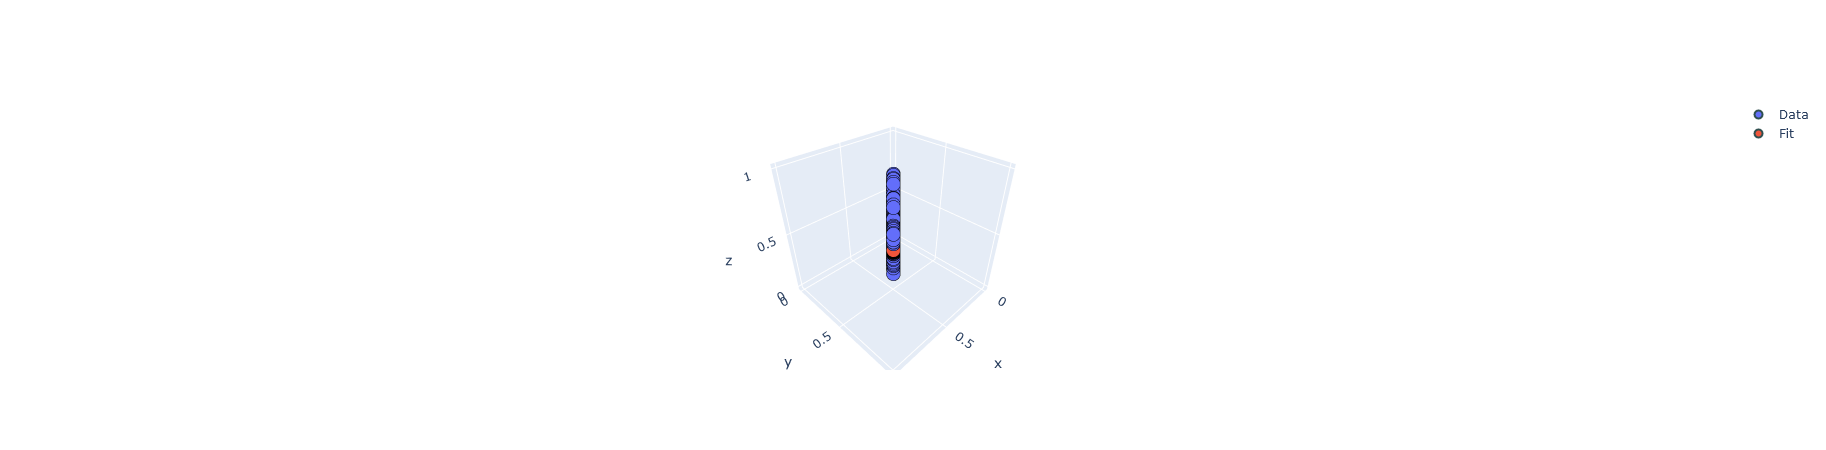

Violated Constraints: 62 from 75 


In [18]:
# try CV on multi dim dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

m2 = ( ('s(1)', 'smooth', 25, (1, 1000), "quantile"), 
       ('s(2)', 'inc', 25, (2, 2000), "quantile"),  
       ('t(1,2)', 'smooth', (5, 5), (3, 3000), "quantile"), )

M2 = Model(descr=m2)

X = pd.DataFrame(data={"x1": np.linspace(-2,2,1000),   
                       "x2": np.linspace(0,1,1000), }) #,
                       #"x3": np.linspace(-2,2,1000), "x4": np.linspace(0,1,1000),
                       #"x5": np.linspace(-2,2,1000), "x6": np.linspace(0,1,1000)})
y = pd.DataFrame(data={"y": 2*np.exp(-X["x1"]**2) + 0.1*np.exp(X["x2"]) + 
                       0.1*np.random.randn(len(X["x1"])) + X["x1"] * X["x2"]  })

X_norm = MinMaxScaler().fit_transform(X)
y_norm = MinMaxScaler().fit_transform(y)

f2 = M2.fit(X=X_norm, y=y_norm.ravel(), plot_=True)
#M2.calc_GCV(X=X_norm, y=y_norm, n_grid=2)

Iteration converged!
Violated Constraints: 1 from 35 


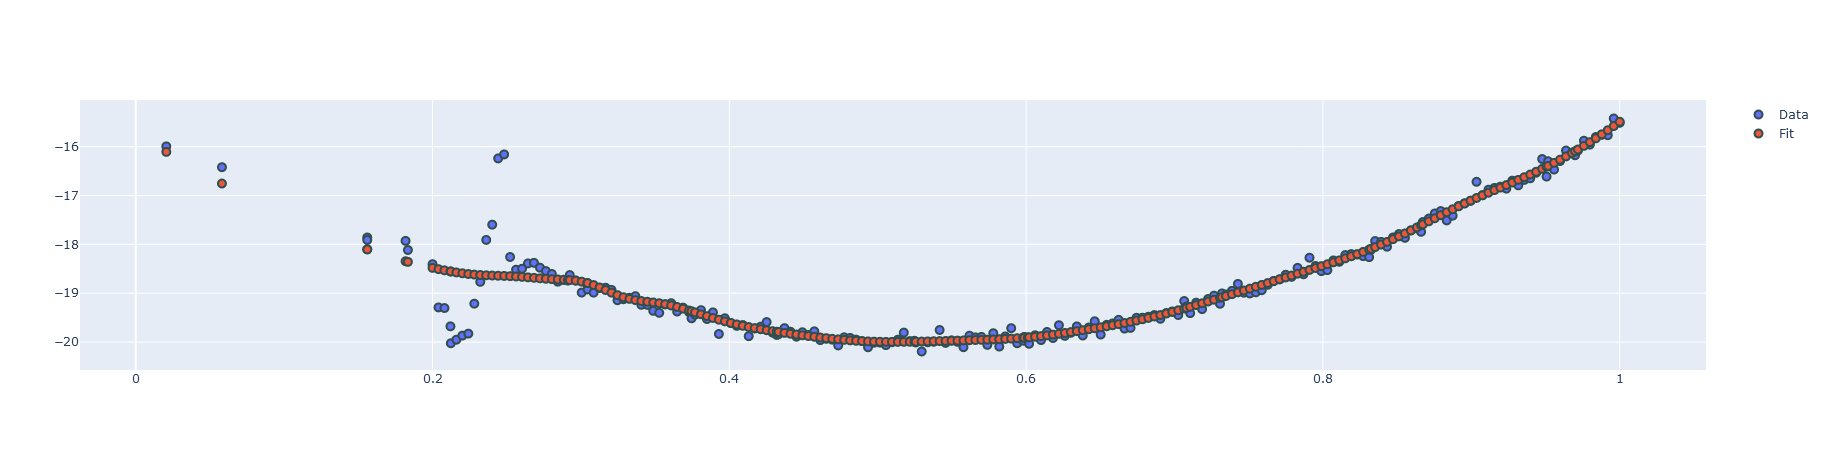

In [8]:
# try CV on 1-d dataset

# generate data
np.random.seed(42)
x_dense = np.random.random(20) * 1

x_sparse = np.linspace(0.2,1,200)
x_dense.sort()
x=np.concatenate((x_dense, x_sparse))
x = x.reshape((len(x), 1))
y = -20*np.exp(-(x-0.5)**2) + 0.1*np.random.randn(len(x), 1)
#y = x**2 + 0.1*np.random.randn(len(x), 1)


# generate parameter grid

m1 = (("s(1)", "valley", 35, (1, 1000), "quantile"),)
M1 = Model(descr=m1)
y_pred = M1.fit(X=x, y=y.ravel(), plot_=True)
#M1.calc_GCV(X=x, y=y.ravel(), n_grid=2, p_min=1e-2, plot_=True)

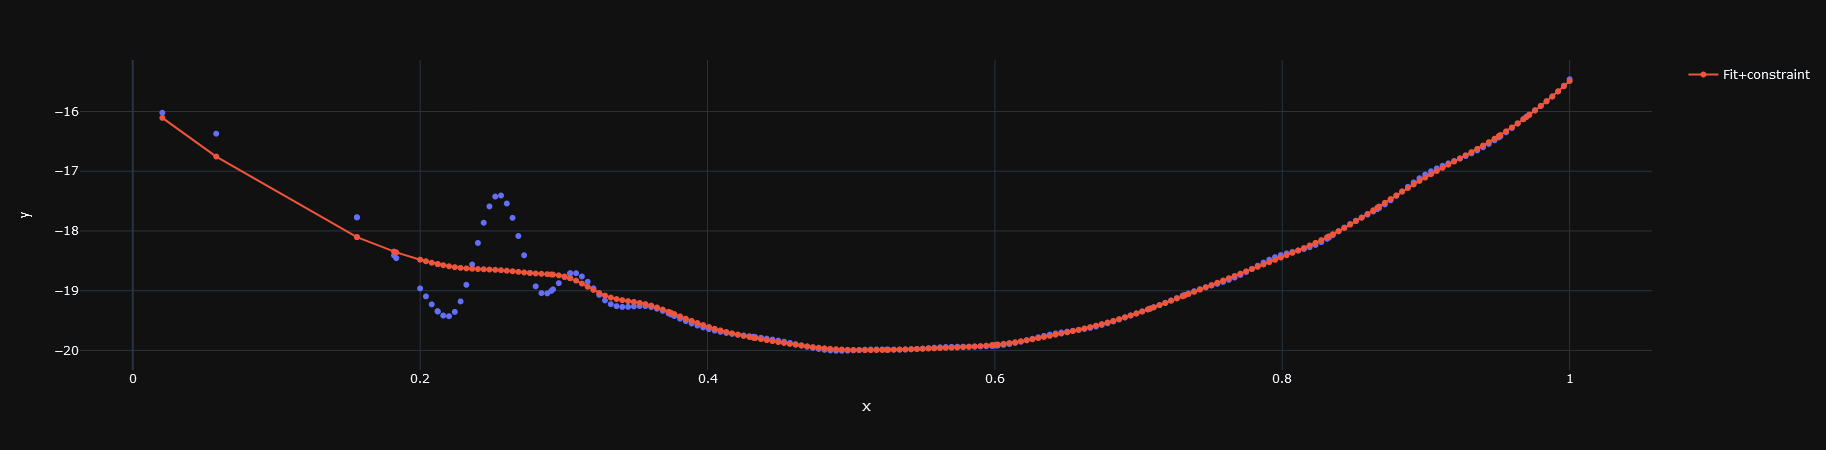

In [9]:
fig = px.scatter(x=x.ravel(), y=M1.basis @ M1.LS_coef_)
fig.add_trace(go.Scatter(x=x.ravel(), y=M1.basis @ M1.coef_, mode="markers+lines", name="Fit+constraint"))
fig.update_layout(template="plotly_dark")
fig.show()

In [3]:
import numpy as np
from stareg.star_model import StarModel
from stareg.utils import check_constraint_full_model

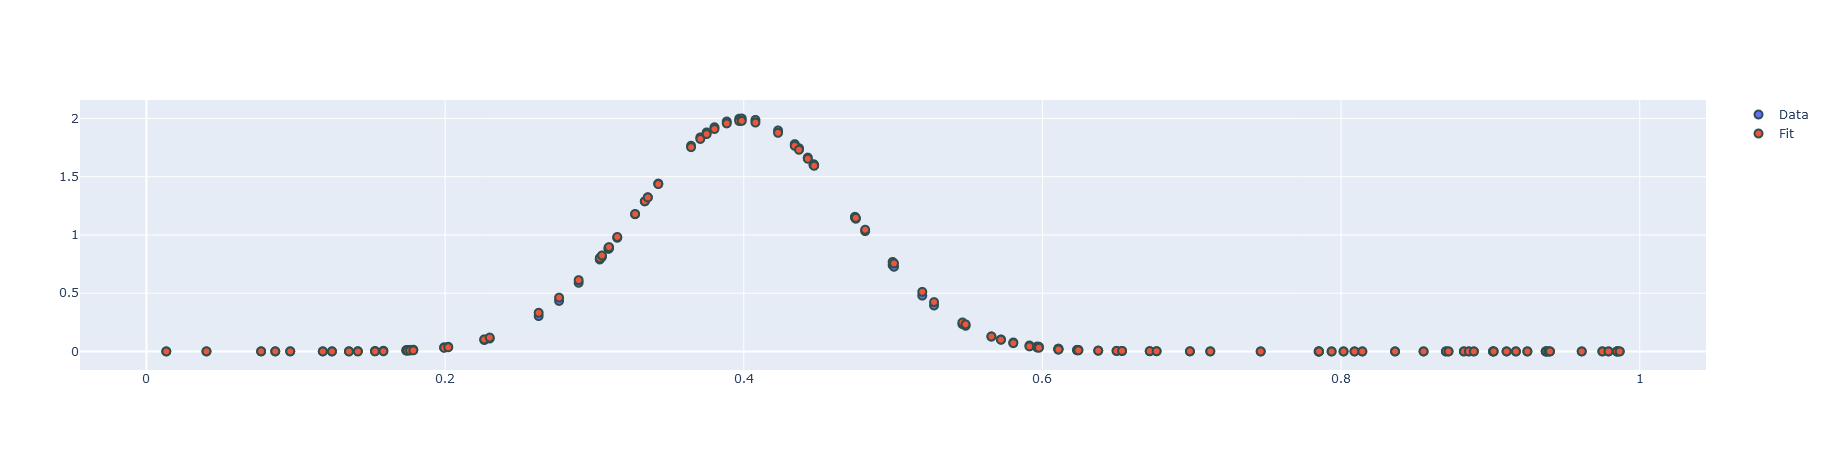

Violated Constraints: 5 from 20 
5


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0])

In [4]:
x = np.random.random(100)
x.sort()
x = x
y = 2*np.exp(-(x - 0.4)**2 / 0.01)
n_param = 20
descr = ( ("s(1)", "peak", n_param, (0.1, 1), "quantile"), )
M = StarModel(descr=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)
v = check_constraint_full_model(model=M)
print(v.sum())
v


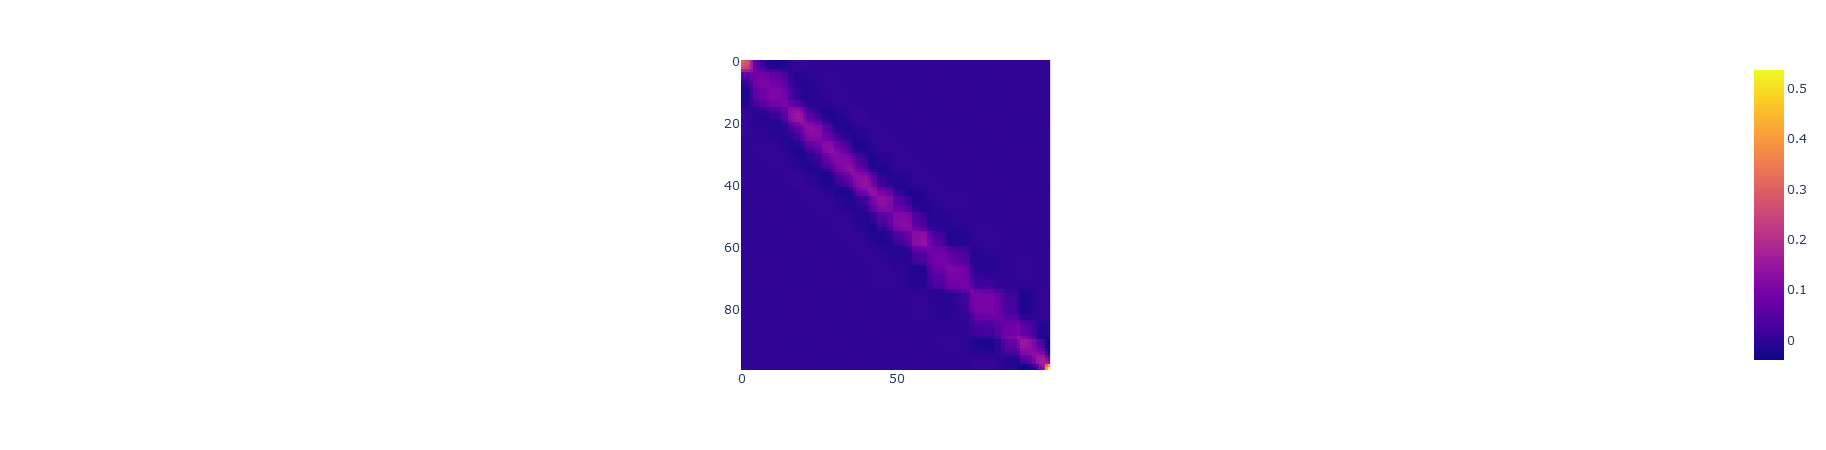

12.536584026003531

In [41]:
px.imshow(M.calc_hat_matrix()).show()
np.trace(M.calc_hat_matrix())


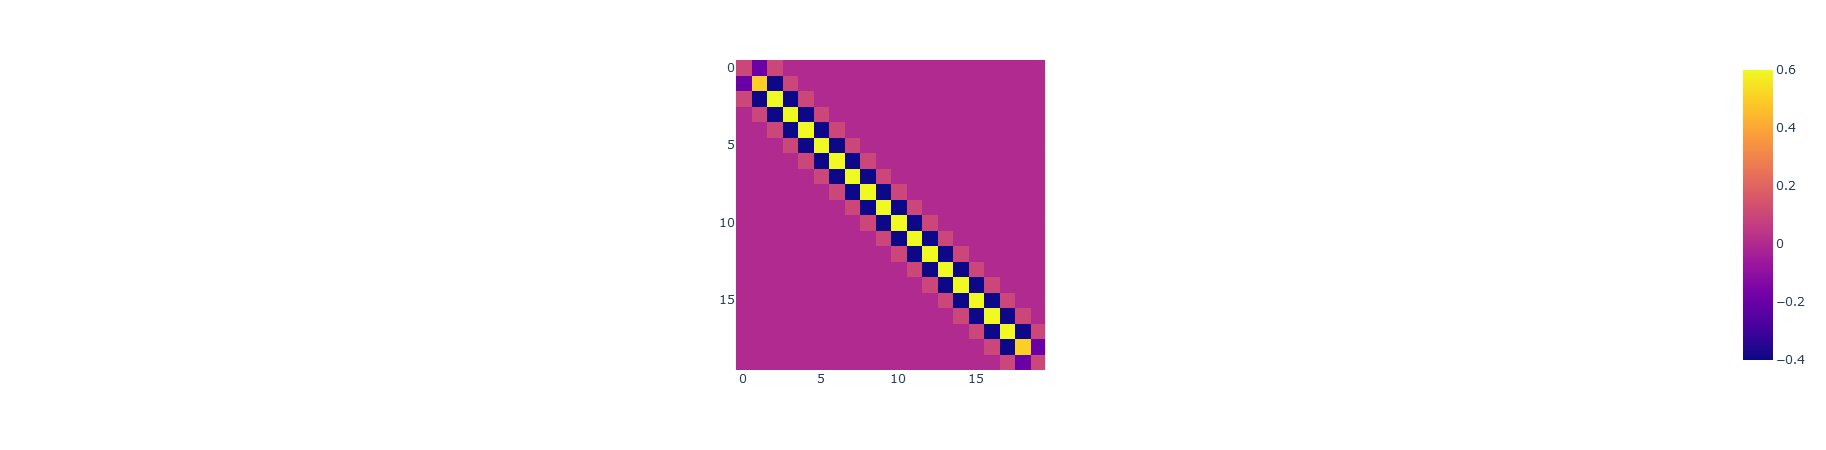

In [38]:

px.imshow(M.smoothness_penalty_list[0])


In [8]:
10**2

100

GCV iteration idx:  0
GCV iteration idx:  1
GCV iteration idx:  2
GCV iteration idx:  3
GCV iteration idx:  4
GCV iteration idx:  5
GCV iteration idx:  6
GCV iteration idx:  7
GCV iteration idx:  8
GCV iteration idx:  9
GCV iteration idx:  10
GCV iteration idx:  11
GCV iteration idx:  12
GCV iteration idx:  13
GCV iteration idx:  14
GCV iteration idx:  15
GCV iteration idx:  16
GCV iteration idx:  17
GCV iteration idx:  18
GCV iteration idx:  19
GCV iteration idx:  20
GCV iteration idx:  21
GCV iteration idx:  22
GCV iteration idx:  23
GCV iteration idx:  24
GCV iteration idx:  25
GCV iteration idx:  26
GCV iteration idx:  27
GCV iteration idx:  28
GCV iteration idx:  29
GCV iteration idx:  30
GCV iteration idx:  31
GCV iteration idx:  32
GCV iteration idx:  33
GCV iteration idx:  34
GCV iteration idx:  35
Best fit parameter according to adapted-GCV score: {'s(1)_constraint': 100.0, 's(1)_smoothness': 10.0}
Violated Constraints: 0 from 20

--- BEST FIT ACCORDING TO GCV ---


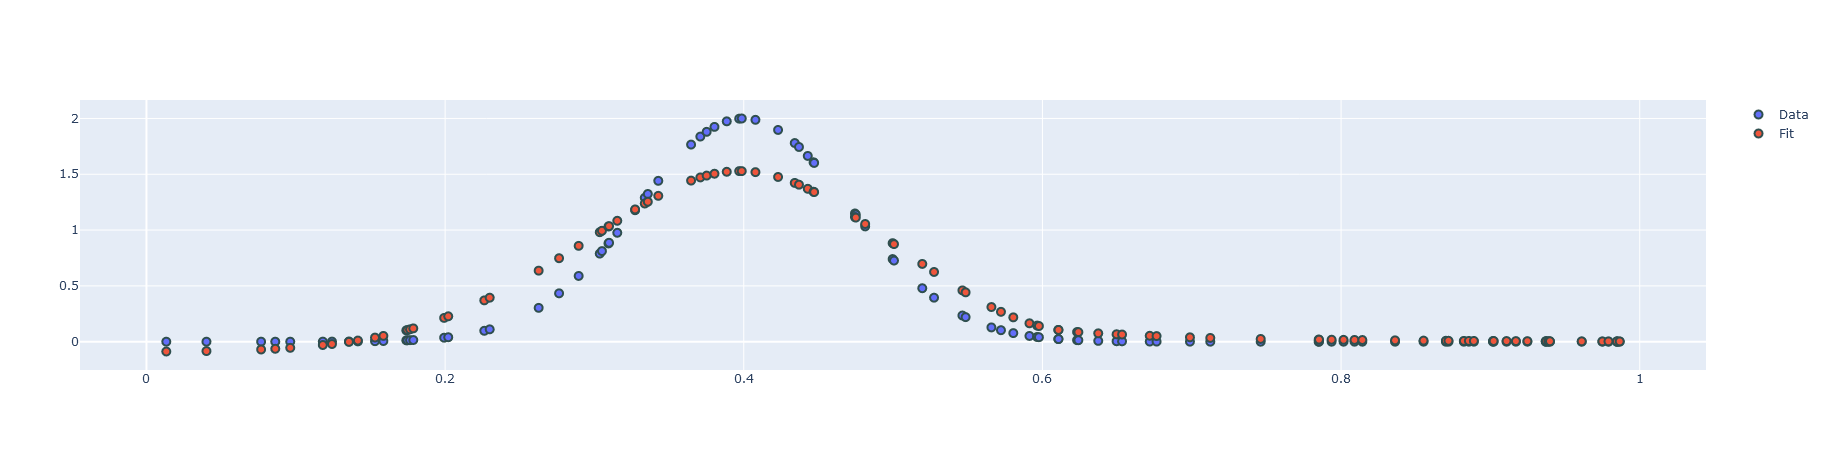

Violated Constraints: 0 from 20 


StarModel(s(1)={'constraint': 'peak', 'knot_type': 'quantile',
                'lam': {'constraint': 100.0, 'smoothness': 10.0},
                'n_param': 20})

In [13]:
M.calc_GCV(X=x.reshape(-1,1), y=y, n_grid=6)

In [12]:

M.smooths